<a href="https://colab.research.google.com/github/cwils021/NFL-Analysis/blob/main/NFL_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NFL Data EDA

## To Run Notebook:

1. Ensure kaggle.json is accessible on local machine
2. Select "runtime" from top menu
3. Select run all (alternativly crtl + f9 is the keyboard shortcut)
4. upload kaggle.json when prompted
5. First run will take approx 3-4 mins to complete

## load data to Colab

In [ ]:
! pip install -q kaggle
from google.colab import files

#################################################################################################
#                                                                                               #
#   Need to download own kaggle.json to be able to load data directly from kaggle               #
# 1. Sign into Kaggle (can sign in using google etc.)                                           #
# 2. Navigate to account page, scroll down to API section and select create new api token       #
#    this is your kaggle.json file                                                              #
# 3. next line of code will prompt for location of kaggle.json file                             #
#                                                                                               #
#################################################################################################                                                                                                

# select kaggle.json from local memory; 
files.upload()

In [ ]:
# Download and unzip data files from kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tobycrabtree/nfl-scores-and-betting-data

! unzip nfl-scores-and-betting-data.zip
! mkdir nfl-datasets
! mv *.csv /content/nfl-datasets/
! pip install -q geopandas
! pip install -q geopy
! pip install -q geographiclib

## load and clean data

In [ ]:
import numpy as np
import pandas as pd
import re
import chardet
import collections
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy import distance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from geographiclib.geodesic import Geodesic

'''
remove_zipcode  -> function to remove zip code (defined as 5 consecutive digits only) from address string

@param address  -> address string

returns address -> if a zip code is found in address, address string with zip code removed returned, 
                   else address is passed back unchanged 
'''
def remove_zipcode(address):
  zip_re = "[0-9]{5}"

  return re.sub(zip_re, "", address)

# create game_id to be able to join with elo data
def create_game_id(date, home_team_id, away_team_id):
  date_str = date.strftime('%Y%m%d')
  game_id = str(date_str + home_team_id + away_team_id)
  return game_id



In [17]:
# load required data to data frames
stadium_data = pd.read_csv(r"/content/nfl-datasets/nfl_stadiums.csv", encoding = "latin-1")
game_data = pd.read_csv("/content/nfl-datasets/spreadspoke_scores.csv")
teams = pd.read_csv('/content/nfl-datasets/nfl_teams.csv')
elo = pd.read_csv("https://projects.fivethirtyeight.com/nfl-api/nfl_elo.csv")

elo['date'] = pd.to_datetime(elo.loc[:,'date'], infer_datetime_format=True)
date_cutoff = pd.to_datetime("1966-09-01")
_pre66_mask = (elo['date'] > date_cutoff) 
elo66 = elo.loc[_pre66_mask]

elo66 = elo66.replace({'team1':'OAK', 'team2':'OAK'},  'LVR')


# split city and team name into seperate columns
new = game_data['team_home'].str.rsplit(" ", 1, expand = True)
game_data["home_city"] = new[0]
game_data["home_teamname"] = new[1]
new = game_data['team_away'].str.rsplit(" ", 1, expand = True)
game_data["away_city"] = new[0]
game_data["away_teamname"] = new[1]

# add team id col
home_team_id = game_data['team_home'].replace(
    teams.set_index('team_name')['team_id'])
away_team_id = game_data['team_away'].replace(
    teams.set_index('team_name')['team_id'])
game_data.insert(4, "home_team_id", home_team_id)
game_data.insert(5, "away_team_id", away_team_id)
                     

# rearrange column order
_temp = game_data[['home_city','home_teamname', 'away_city', 'away_teamname']]
game_data.drop(labels=['home_city','home_teamname', 'away_city', 'away_teamname'], axis = 1, inplace= True)
for i in range(4):
  col_name = _temp.columns[i]
  game_data.insert((i + 5),col_name , _temp.iloc[:,i])

# convert date to datetime and add string date column
game_data['schedule_date'] = pd.to_datetime(game_data['schedule_date'], infer_datetime_format= True)
_temp = game_data['schedule_date'].dt.strftime("%a %b %d, %Y")
game_data.insert(0, "date_string", _temp)

# add missing score from superbowl LV
_sb_lv_idx = game_data.loc[game_data['schedule_date'] == pd.to_datetime("2/7/2021")].index[0]
game_data.iat[_sb_lv_idx, game_data.columns.get_loc("score_away")] = 9 
game_data.iat[_sb_lv_idx, game_data.columns.get_loc("score_home")] = 31 

# convert scores to integer type
game_data[['score_home', 'score_away']] = game_data[['score_home', 'score_away']].astype(np.int64)

# create and add result column next to scores 1 = home team wins, 0 = away team wins
game_data['result'] = np.where(game_data['score_home'] > game_data['score_away'], 1, 0)
_temp = game_data['result']
game_data.drop(columns=['result'], inplace=True)
game_data.insert(11, "result", _temp)

# copy stadium names and addresses to new df
stadiums = stadium_data[['stadium_name', 'stadium_address' ]]

# merge stadium addresses with game_data df, dropping duplicate stadium name col
game_data = game_data.merge(stadiums, "left", left_on= "stadium", right_on="stadium_name",
                validate = "m:1").drop(
                    columns = ["stadium_name"])
# add stadium address column next to stadium name in game data
_temp = game_data['stadium_address']
game_data.drop(columns=['stadium_address'], inplace= True)
game_data.insert(20, "address", _temp)

# create distance travelled for
game_data["dt_for_home"] = 0
game_data["dt_for_away"] = -1

# print("# of rec without address: " + str(len(game_data[game_data['address'].isna()])))
# print("# of stadiums without address: " + str(len(stadiums[stadiums['stadium_address'].isna()])))
# print(stadiums[stadiums['stadium_address'].isna()])

# fill missing addresses
allegiant_stadium = "3333 Al Davis Way, Las Vegas, NV 89118, United States"
alltel_stadium = "1 TIAA Bank Field Dr, Jacksonville, FL 32202, United States"
dolphin_stadium = "347 Don Shula Dr, Miami Gardens, FL 33056, United States"
jack_murphy = "9449 Friars Rd, San Diego, CA 92108, United States"
joe_robbie = "347 Don Shula Dr, Miami Gardens, FL 33056, United States"
merc_benz = "409 Nelson St SW, Atlanta, GA 30313, United States"
pro_player = "347 Don Shula Dr, Miami Gardens, FL 33056, United States"
rose_bowl = "1001 Rose Bowl Dr, Pasadena, CA 91103, United States"
sofi = "1000 S Prairie Ave, Inglewood, CA 90301, United States"
stanford = "625 Nelson Rd, Stanford, CA 94305, United States"
tampa = "4201 N Dale Mabry Hwy, Tampa, FL 33607, United States"
yankee = "1 E 161 St, The Bronx, NY 10451, United States"

# create list of stadiums with missing/incorrect addresses in game_data
missing_stadiums = "Allegiant Stadium, Alltel Stadium, Dolphin Stadium, Jack Murphy Stadium, Joe Robbie Stadium, Mercedes-Benz Stadium, Pro Player Stadium, Rose Bowl, SoFi Stadium, Stanford Stadium, Tampa Stadium, Yankee Stadium"
missing_stadiums = missing_stadiums.split(", ")

found_addresses = [allegiant_stadium, alltel_stadium, dolphin_stadium,
                       jack_murphy, joe_robbie, merc_benz, pro_player,
                       rose_bowl, sofi, stanford, tampa, yankee]

# dictionary of stadiums and corressponding confirmed address
address_mapper = dict(zip(missing_stadiums, found_addresses))

# add additional missing/incorrect addresses to dictionary
address_mapper['FedEx Field'] = "1600 Fedex Way, Landover, MD 20785, United States"
address_mapper['Fenway Park'] = "4 Jersey St, Boston, MA 02215, United States"
address_mapper['Legion Field'] = "400 Graymont Ave W, Birmingham, AL 35204, United States"
address_mapper['TIAA Bank Field'] = "1 TIAA Bank Field Dr, Jacksonville, FL 32202, United States"
address_mapper['Tottenham Hotspur Stadium'] = "782 High Rd, Tottenham, London N17 0BX, United Kingdom"
address_mapper['Tottenham Stadium'] = "782 High Rd, Tottenham, London N17 0BX, United Kingdom"

# fill in missing addresses and remove zip codes
game_data.address = game_data.address.fillna(game_data.stadium.map(address_mapper))
game_data['address'] = game_data['address'].apply(remove_zipcode)

# fix vikings city 
vikings_home = (game_data['home_teamname'] == 'Vikings')
game_data.loc[vikings_home, 'home_city'] = 'Minneapolis'
vikings_away = (game_data['away_teamname'] == 'Vikings')
game_data.loc[vikings_away, 'away_city'] = 'Minneapolis'

#change to current name
giants_stadium = (game_data['stadium'] == 'Giants Stadium')
game_data.loc[giants_stadium, 'stadium'] = 'Metlife Stadium'

# change to current stadium name
dolphin_stadium = (game_data['stadium'] == 'Dolphin Stadium')
game_data.loc[dolphin_stadium, 'stadium'] = 'Hard Rock Stadium'

# fix remaining home/away_city
state_to_city = {'Arizona':'Phoenix', 'Carolina':'Charlotte', 
                 'New England': 'Foxborough', 'Washington': 'Ashburn',
                 'Washington Football': 'Ashburn' }

game_data.loc[game_data['home_city'].isin(state_to_city.keys()), 'home_city'] = game_data['home_city'].map(state_to_city)
game_data.loc[game_data['away_city'].isin(state_to_city.keys()), 'away_city'] = game_data['away_city'].map(state_to_city)

kaggle_game_ids = game_data.apply(lambda x: create_game_id(x['schedule_date'],
                                             str(x['home_team_id']), str(x['away_team_id'])), axis = 1)
elo66_game_ids = elo66.apply(lambda x: create_game_id(x['date'],
                                             str(x['team1']), str(x['team2'])), axis = 1)
game_data.insert(0, "game_id", kaggle_game_ids)
elo66.insert(0, "game_id", elo66_game_ids)

print(game_data['game_id'].nunique())
print(elo66['game_id'].nunique())


12947
12989


In [ ]:
set(game_data['away_city']).union(game_data['home_city'])

Import Geopy and calculate Distance for Away Team

In [19]:
# setup geopy

geolocator = Nominatim(user_agent="NFL-eda")
geocoder = RateLimiter(geolocator.geocode, min_delay_seconds = 1)


In [20]:
point_cache = {}    # to minimize calls to Nominatim

'''
get_point          -> function to get lat, long of address

@param address     -> address to geocode
@param point_cache -> dictionary of addresses previously geocoded

returns point      -> (tuple) lat, long of address
'''
def get_point(address, point_cache):
  if address in point_cache.keys():
    return point_cache.get(address)
  else:
    geo = geocoder(address)
    if geo:
      point = tuple([geo.point[0], geo.point[1]])
    else:
      point = tuple()
    
    point_cache[address] = point
    return point

'''
get_distance_travelled -> function to calculate distance travelled using geodisc of
                           ellipsoid (https://en.wikipedia.org/wiki/Geodesics_on_an_ellipsoid)

@param start           -> starting address 
@param dest            -> destination address
@param point_cache     -> dictionary of addresses previously geocoded
    
returns dist           -> (float)distance between start and dest in miles 
'''
def get_distance_travelled(start, dest, point_cache):  
  # get points using get_point
  start_point = get_point(start, point_cache)
  dest_point = get_point(dest, point_cache)
  
  # if both points valid calculate distance else return -1
  if all(start_point) & all(dest_point):
    dist = distance.distance(start_point, dest_point).miles
    return dist
  else:
    return -1

In [21]:
# change stadium names to current if only renamed, to avoid geocoding errors
game_data['stadium'] = game_data.apply(lambda x: "TIAA Bank Field" if x['stadium'] == "Alltel Stadium" else x['stadium'], axis = 1)
game_data['stadium'] = game_data.apply(lambda x: "TIAA Bank Field" if x['stadium'] == "EverBank Field" else x['stadium'], axis = 1)
game_data['address'] = game_data.apply(lambda x: "South Capitol Avenue, Indianapolis" if x['stadium'] == "RCA Dome" else x['address'], axis = 1)


In [ ]:
# clear cache to ensure no old errenous points are not carried over from previous runs
point_cache.clear()

# calculate distance travelled by team (approximated by distance from away team city to home stadium)
game_data['dt_for_away'] = game_data.apply(lambda x: get_distance_travelled(x['away_city']
                                                                            , x['address'],
                                                                            point_cache),
                                            axis = 1)

In [23]:
# recalculate distances flagged as errors
point_cache.clear()
game_data['dt_for_away'] = game_data.apply(lambda x: get_distance_travelled(x['away_city'], x['stadium'], point_cache) if x['dt_for_away'] > 5000 else x['dt_for_away'], axis = 1)

In [ ]:
# investigating large distance
print(len(game_data.loc[game_data['dt_for_away'] >= 3100]))
game_data.loc[game_data['dt_for_away'] >= 3100]   # expect only UK Games to be output


In [25]:
# set dual team city games (i.e New York Giants vs New York Jets (both play out of Metlife Stadium)) to 0
mask = game_data['dt_for_away'] < 25
game_data.loc[mask, 'dt_for_away'] = 0

In [ ]:
# random sampling for error checking
# re running this cell displays new random row
'''
dt_for_away_sanity_checker -> function that prints a random row from df for random spot checking

@param game_data           -> game_data data frame

returns                    -> None
'''
def dt_for_away_sanity_checker(game_data):
  i = np.random.randint(0, len(game_data))
  print(game_data.iloc[i,:])

dt_for_away_sanity_checker(game_data)

## Analysis of Away Team Distance Travelled

### EDA

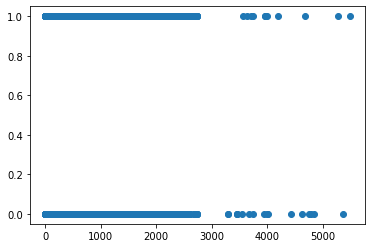

In [27]:
# simple scatter plot for result vs distance travelled
plt.scatter(game_data['dt_for_away'], game_data['result'])

- more losses when 3000 < distance < 5000 (UK Games, "Home team" is also travelling, possibly even farther

### ML Model using sklearn Logistic Model

In [28]:
# make a copy of just result and away team distance travelled
model_data = game_data.loc[:,["result", "dt_for_away"]]
model_data

# split into train and test (75% train / 25% test)
X_train, X_test, y_train, y_test = train_test_split(model_data[['dt_for_away']], model_data.result, test_size = 0.25, random_state = 0) 

In [29]:
# fit Logistic Regression ML Model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
model.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [31]:
log_probs = model.predict_log_proba(X_test)
log_probs

array([[-0.84452575, -0.56169993],
       [-0.8559398 , -0.55318299],
       [-0.83756   , -0.56698192],
       ...,
       [-0.8359478 , -0.56821369],
       [-0.86319702, -0.54785514],
       [-0.84047661, -0.56476243]])

In [32]:
model.predict_proba(X_test)

array([[0.42976113, 0.57023887],
       [0.4248837 , 0.5751163 ],
       [0.43276518, 0.56723482],
       ...,
       [0.43346345, 0.56653655],
       [0.42181138, 0.57818862],
       [0.43150481, 0.56849519]])

In [33]:
model.score(X_test, y_test) * 100

57.738646895273405

### traditional glm logistic regression

In [34]:
# build traditional GLM LR model; Output reads different but results are the same as in R
mod = sm.GLM(model_data['result'], sm.add_constant(model_data['dt_for_away']), family=sm.families.Binomial())
mod.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 result   No. Observations:                12947
Model:                            GLM   Df Residuals:                    12945
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8836.4
Date:                Mon, 12 Apr 2021   Deviance:                       17673.
Time:                        01:07:33   Pearson chi2:                 1.29e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2625      0.032      8.296      0.000       0.200       0.324
dt_for_away  3.018e-05   2.62e-05      1.151      0.250   -2.12e-05    8.16e-05
===============================================================================
"""

#### R Code & Output Using Same Model and Data



```{r}
mod <- glm(result ~ dt_for_away, data = distance_of_awayteam_data, family = "binomial")
summary(mod)

Call:
glm(formula = result ~ dt_for_away, family = "binomial", data = distance_of_awayteam_data)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.357  -1.300   1.046   1.058   1.067  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) 2.648e-01  3.183e-02   8.321   <2e-16 ***
dt_for_away 2.766e-05  2.630e-05   1.052    0.293    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17674  on 12946  degrees of freedom
Residual deviance: 17673  on 12945  degrees of freedom
AIC: 17677

Number of Fisher Scoring iterations: 4
```



- **above numbers slightly off, invalid rows were found post running this R analysis**
- As expected distance travelled alone is not a significant explanatory var on its own
- given the large size of distance, try model using log(distance) instead
- I believe it is the box-cox test is a formal test for determining what transformation may work best

#### log distance column

In [35]:
# create log distance column
model_data['log_dist'] = np.log(model_data['dt_for_away'], where = model_data['dt_for_away'] > 0)

# create and fit log(distance) model
mod2 = sm.GLM(model_data['result'], sm.add_constant(model_data['log_dist']), family=sm.families.Binomial())
mod2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 result   No. Observations:                12947
Model:                            GLM   Df Residuals:                    12945
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8834.8
Date:                Mon, 12 Apr 2021   Deviance:                       17670.
Time:                        01:07:33   Pearson chi2:                 1.29e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.139     -0.021      0.983      -0.276       0.270
log_dist       0.0446      0.021      2.139      0.032       0.004       0.086
==============================================================================
"""

#### R Code & Output for Model 2 (Log(Distance))



```{r}
mod2 <- glm(result ~ log(dt_for_away), data = distance_of_awayteam_data, family = "binomial")
summary(mod2)

Call:
glm(formula = result ~ log(dt_for_away), family = "binomial", 
    data = distance_of_awayteam_data)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.340  -1.303   1.040   1.055   1.135  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)  
(Intercept)       0.01556    0.14391   0.108   0.9139  
log(dt_for_away)  0.04175    0.02153   1.940   0.0524 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17674  on 12946  degrees of freedom
Residual deviance: 17670  on 12945  degrees of freedom
AIC: 17674

Number of Fisher Scoring iterations: 4
```



- **above numbers slightly off, invalid rows were found post running this R analysis**
- logging the distance seems to have improved the model ever so slighty (see drop in AIC)
- log(distance) is significant at $\alpha$ = 0.1
- some, but not much evidence that distance travelled by away team has a positive effect on home team chances of winning a given game
- slight difference in results likely due to differences in rounding between programs

### Export Away Team Distance Analysis

In [36]:
# Uncomment below to export to .xlsx
# model_data.to_excel("distance-of-awayteam-data.xlsx")
# game_data.to_excel("NFL_game_data.xlsx", index_label= "idx")

## Analysis of Home Team Distance Travelled

In [37]:
_mask = (game_data['stadium_neutral'] == True)
neutral_games = game_data[_mask]
point_cache.clear()
game_data.loc[_mask,'dt_for_home'] =  neutral_games.apply(lambda x: 
                                                    get_distance_travelled(
                                                        x['home_city'],
                                                        x['address'],
                                                        point_cache),
                                                    axis=1)

In [38]:
game_data.dt_for_home.groupby(pd.cut(game_data['dt_for_home'],[0, 50, 100, 1000, 3000,100000])).count()


dt_for_home
(0, 50]            2
(50, 100]          6
(100, 1000]       21
(1000, 3000]      24
(3000, 100000]    46
Name: dt_for_home, dtype: int64

In [39]:
incorrect_address_mask = (game_data['dt_for_home'] > 3000)
point_cache.clear()
game_data.loc[incorrect_address_mask, 'dt_for_home'] = game_data[incorrect_address_mask].apply(lambda x: 
                                                    get_distance_travelled(
                                                        x['home_city'],
                                                        x['stadium'],
                                                        point_cache),
                                                    axis=1) 

In [41]:
game_data.dt_for_home.groupby(pd.cut(game_data['dt_for_home'],[-1, 25, 100, 1000, 3000,100000])).count()

dt_for_home
(-1, 25]          12849
(25, 100]             7
(100, 1000]          27
(1000, 3000]         36
(3000, 100000]       28
Name: dt_for_home, dtype: int64

In [46]:
pd.set_option('display.max_rows', None)
col_mask = ['home_city', 'away_city', 'stadium', 'address', 'dt_for_home', 'dt_for_away']
game_data.loc[(game_data['dt_for_home'] > 1000), col_mask].sort_values(by='dt_for_home', ascending = False)

,home_city,away_city,stadium,address,dt_for_home,dt_for_away
11975,Los Angeles,Phoenix,Twickenham Stadium,"200 Whitton Road, TW2 7BA, London, UK",5448.926695,5277.157425
11709,Los Angeles,New York,Twickenham Stadium,"200 Whitton Road, TW2 7BA, London, UK",5448.926695,3462.870883
12526,Los Angeles,Cincinnati,Wembley Stadium,"Wembley, London HA9 0WS, United Kingdom",5446.312271,3958.448606
12243,Los Angeles,Tennessee,Wembley Stadium,"Wembley, London HA9 0WS, United Kingdom",5446.312271,4187.081133
10122,San Francisco,Denver,Wembley Stadium,"Wembley, London HA9 0WS, United Kingdom",5360.699264,4690.243069
12483,Oakland,Chicago,Tottenham Hotspur Stadium,"782 High Rd, Tottenham, London N17 0BX, United...",5358.710787,3957.978905
12233,Oakland,Seattle,Tottenham Stadium,"782 High Rd, Tottenham, London N17 0BX, United...",5358.710787,4795.703110
11132,Oakland,Miami,Wembley Stadium,"Wembley, London HA9 0WS, United Kingdom",5354.832403,4427.874353
9584,New Orleans,San Diego,Wembley Stadium,"Wembley, London HA9 0WS, United Kingdom",4629.241217,5487.333943
12501,Tampa Bay,Charlotte,Tottenham Hotspur Stadium,"782 High Rd, Tottenham, London N17 0BX, United...",4441.205782,4000.820063


In [47]:
# set distance less than 50 miles to zero (teams in same area i.e Giants/Jets)
game_data.loc[game_data['dt_for_away'] < 51, 'dt_for_away'] = 0


## get bearings 

In [48]:
'''
get_bearing            -> function to calculate bearing of travel
                           

@param start           -> starting address 
@param dest            -> destination address
@param point_cache     -> dictionary of addresses previously geocoded
    
returns dist           -> (float)distance between start and dest in miles 
'''
def get_bearing(start, dest, point_cache):  
  # get points using get_point
  start_point = get_point(start, point_cache)
  dest_point = get_point(dest, point_cache)
  
  # if both points valid calculate distance else return -1
  try:
    azimuth = Geodesic.WGS84.Inverse(start_point[0], start_point[1],
                                     dest_point[0], dest_point[1], outmask = 512)['azi1']
    bearing = azimuth
    if bearing < 0: bearing += 360
    
    return bearing
  except IndexError:
    return 1000  

In [49]:
_point1 = "Toronto ON"
_point2 = "Guelph ON"

print("p1: " + str(get_point(_point1, point_cache={})))
print("p2: " + str(get_point(_point2, point_cache={})))

get_bearing(_point1, _point2, point_cache={})

p1: (43.6534817, -79.3839347)
p2: (43.5460516, -80.2493276)


260.60491445680526

In [50]:
_away_mask = (game_data['dt_for_away'] > 0)
game_data['bearing_away'] = 0
game_data.loc[_away_mask, 'bearing_away'] = game_data[_away_mask].apply(lambda x: get_bearing(x['away_city'], x['address'], point_cache), axis = 1)

In [33]:
_address_mask = (game_data['bearing_away'] == 1000)
game_data.loc[_address_mask,'bearing_away'] = game_data[_address_mask].apply(lambda x: get_bearing(x['away_city'], x['stadium'], point_cache), axis = 1)

In [51]:
def get_compass_direction(bearing):
  if bearing > 0.0 and bearing < 90.0:
    return "NE"
  elif bearing >= 90.0 and bearing < 180.0:
    return "SE"
  elif bearing >= 180.0 and bearing < 270.0:
    return "SW"
  elif bearing >= 270.0 and bearing < 360.0:
    return "NW"
  else:
    return "N/A"

In [52]:
game_data['compass_away'] = game_data['bearing_away'].apply(get_compass_direction)

In [62]:
game_data.groupby(['compass_away'])['game_id'].count()

compass_away
N/A    2157
NE     3201
NW     3214
SE     1776
SW     2599
Name: game_id, dtype: int64

## Exploring missings rows in Kaggle (post presentation)

- 48 missing games in 87 season compared to elo dataset

In [37]:
# print("diff elo - elo66: " + str(len(elo) - len(elo[elo['date'] > date_cutoff])))
# print(len(game_data))
# print("diff kaggle - ELO66: " + str(len(game_data) - len(elo66)))

In [38]:
# group_kaggle = game_data['schedule_season'].groupby(game_data['schedule_season']).count()

In [39]:
# print(elo66.head())
# print(elo66.tail())

In [40]:
# print(len(elo66))

In [41]:
# group_538 = elo66['season'].groupby(elo66['season']).count()

In [42]:
# print(len(group_538))
# print(len(group_kaggle))

In [43]:
# print(group_538.equals(group_kaggle))


In [44]:
# ps_538 = pd.Series(group_538)
# ps_kaggle = pd.Series(group_kaggle)
# print(ps_kaggle)
# ps_538[ps_538 != ps_kaggle]

# 1987 season in kaggle is 177, 219 in elo66

In [45]:
# kaggle87_season_cols = ['schedule_date',  'home_city', 'away_city', 'score_home', 'score_away']
# season1987_kaggle = (game_data['schedule_season'] == 1987)
# kaggle87 = game_data.loc[season1987_kaggle, kaggle87_season_cols]
# elo66_season_cols = ['date',  'team1', 'team2', 'score1', 'score2']
# elo66_87 = (elo66['season'] == 1987)
# elo66_87 = elo66.loc[elo66_87, elo66_season_cols]
# diff = len(elo66_87) - len(kaggle87)
# elo66_87
# kaggle87

# np.setdiff1d(kaggle87['schedule_date'], elo66_87['date'])


## Pull Betting Data Only

In [46]:
# game_data.columns

In [47]:
# betting_data_cols = ['schedule_date', 'schedule_season','home_city', 'home_teamname', 'away_city',
#        'away_teamname', 'score_home', 'score_away', 'result',
#        'team_favorite_id', 'spread_favorite', 'over_under_line']
# betting_data = game_data[betting_data_cols]

In [48]:
# betting_data.dropna(how = 'all',subset=['team_favorite_id', 'spread_favorite', 'over_under_line'], inplace=True)

In [49]:
# betting_data

In [50]:
# team_ids = set(betting_data['team_favorite_id'])
# print(team_ids)

In [51]:
# teams = pd.read_csv('/content/nfl-datasets/nfl_teams.csv')
# team_ids_and_names = teams[['team_id' , 'team_name_short']]
# team_ids_and_names = team_ids_and_names.set_index('team_id')
# team_dict = team_ids_and_names.to_dict()
# team_dict

In [52]:
# team_name = betting_data['team_favorite_id']
# fav_team = team_name.replace(team_ids_and_names['team_name_short'])
# betting_data['fav_to_win'] = fav_team
# _temp = betting_data['fav_team']
# betting_data.drop(labels=['fav_team', 'fav_to_win'], axis = 1, inplace= True)
# betting_data.insert(10, "fav_team", _temp)

In [53]:
# betting_data.to_excel("betting_data_NFL.xlsx")

## Merge ELO66 and game_data


In [66]:
elo66.set_index('game_id', inplace=True)
game_data.set_index('game_id', inplace= True)
print(elo66.head(15))
print(game_data.head(15))
print(elo66.tail(1))
print(game_data.tail(1))


                     date  season  neutral  ...  qbelo2_post score1 score2
game_id                                     ...                           
19660902MIALVR 1966-09-02    1966        0  ...  1534.734433     14     23
19660903TENDEN 1966-09-03    1966        0  ...  1352.452907     45      7
19660904LACBUF 1966-09-04    1966        0  ...  1589.700719     27      7
19660909MIANYJ 1966-09-09    1966        0  ...  1461.170692     14     19
19660910LACNE  1966-09-10    1966        0  ...  1461.341001     24      0
19660910GBIND  1966-09-10    1966        0  ...  1582.179732     24      3
19660910TENLVR 1966-09-10    1966        0  ...  1493.961204     31      0
19660911ATLLAR 1966-09-11    1966        0  ...  1469.668181     14     19
19660911SFMIN  1966-09-11    1966        0  ...  1517.821741     20     20
19660911WSHCLE 1966-09-11    1966        0  ...  1582.851078     14     38
19660911ARIPHI 1966-09-11    1966        0  ...  1442.522381     16     13
19660911PITNYG 1966-09-11

In [67]:
print([item for item, count in collections.Counter(kaggle_game_ids).items() if count > 1])
print([item for item, count in collections.Counter(elo66_game_ids).items() if count > 1])
print(set(elo66['team1']).union(elo66['team2']))


[]
[]
{'WSH', 'LAR', 'CAR', 'CHI', 'GB', 'LVR', 'CIN', 'JAX', 'KC', 'SF', 'NYG', 'PIT', 'IND', 'BUF', 'NYJ', 'HOU', 'ARI', 'NO', 'PHI', 'DET', 'NE', 'TB', 'TEN', 'DAL', 'LAC', 'MIA', 'DEN', 'BAL', 'ATL', 'MIN', 'CLE', 'SEA'}


In [73]:
final_dataset = game_data.merge(elo66, how='inner', left_index=True, right_index=True)

In [74]:
final_dataset.columns

Index(['date_string', 'schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'home_team_id', 'home_city', 'home_teamname',
       'away_city', 'away_teamname', 'away_team_id', 'result', 'team_home',
       'score_home', 'score_away', 'team_away', 'team_favorite_id',
       'spread_favorite', 'over_under_line', 'stadium', 'address',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'weather_detail', 'dt_for_home', 'dt_for_away',
       'bearing_away', 'compass_away', 'date', 'season', 'neutral', 'playoff',
       'team1', 'team2', 'elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2',
       'elo1_post', 'elo2_post', 'qbelo1_pre', 'qbelo2_pre', 'qb1', 'qb2',
       'qb1_value_pre', 'qb2_value_pre', 'qb1_adj', 'qb2_adj', 'qbelo_prob1',
       'qbelo_prob2', 'qb1_game_value', 'qb2_game_value', 'qb1_value_post',
       'qb2_value_post', 'qbelo1_post', 'qbelo2_post', 'score1', 'score2'],
      dtype='object')

In [83]:
final_dataset = final_dataset.drop(labels=['weather_temperature', 'weather_wind_mph','weather_humidity', 'weather_detail','date', 'season', 'neutral', 'playoff','elo1_post', 'elo2_post','qb1_adj','qb2_adj','qb1_game_value', 'qb2_game_value', 'qb1_value_post','qb2_value_post', 'qbelo1_post', 'qbelo2_post','score1', 'score2'], axis = 1)

In [84]:
final_dataset['home_fav'] = [1 if x == y else 0 for (x,y) in zip(final_dataset['home_team_id'], final_dataset['team_favorite_id'])]

In [85]:
final_dataset.to_excel("NFL_final_dataset.xlsx")
final_dataset.to_json("final_dataset.json")

In [87]:
len(final_dataset)

12023